In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
from sklearn import model_selection
import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


<h2>Reading Data</h2>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


<h3>Checking for NULL values </h3>

In [4]:
#Checking whether there are any rows with null values
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

            id    qid1    qid2                         question1  \
105780  105780  174363  174364    How can I develop android app?   
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


Here there are 2 rows with null values in question2

In [5]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h3> Preprocessing of Text </h3>

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [6]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(',000,000', 'm').replace(',000', 'k').replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x) #removing html tags
        x = example1.get_text()
               
    
    return x
    

In [7]:
#preprocessing question1 and question2
df["question1"] = df["question1"].fillna("").apply(preprocess)
df["question2"] = df["question2"].fillna("").apply(preprocess)

## Train, CV, Test split

In [8]:
cols_to_select = [col for col in df.columns if col != 'is_duplicate'];
X = df[cols_to_select]
print(X.columns)
y = df['is_duplicate'];
print(y.shape)

Index(['id', 'qid1', 'qid2', 'question1', 'question2'], dtype='object')
(404290,)


In [9]:
#splitting project_data into train and test and CV data.
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=1)
X_train, X_cv, y_train, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.3, random_state=1);

print('shape of train data ', X_train.shape);
print('shape of test data ', X_test.shape);
print('shape of cross validation data ', X_cv.shape)

shape of train data  (198102, 5)
shape of test data  (121287, 5)
shape of cross validation data  (84901, 5)


In [10]:
X_test.iloc[13696]

id                                                      363362
qid1                                                    493340
qid2                                                    493341
question1                                                     
question2    my chinese name is haichao yu  what english na...
Name: 363362, dtype: object

<h2>Basic Feature Extraction</h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [11]:
def extract_basic_features(df):
    
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count');
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count');
    df['q1Len'] = df['question1'].str.len();
    df['q2Len'] = df['question2'].str.len();
    df['q1_n_words'] = df['question1'].apply(lambda x: len(x.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda x: len(x.split(" ")))

    def normalized_word_common(row):
        q1_words = set(map(lambda x: x.lower().strip(), row['question1'].split(" ")));
        q2_words = set(map(lambda x: x.lower().strip(), row['question2'].split(" ")));
        return 1.0 * len(q1_words & q2_words);

    df['word_Common'] = df.apply(normalized_word_common, axis=1);

    def normalized_word_total(row):
        q1_words = set(map(lambda x: x.lower().strip(), row['question1'].split(" ")));
        q2_words = set(map(lambda x: x.lower().strip(), row['question2'].split(" ")));
        return 1.0 * (len(q1_words) + len(q2_words))
    df['word_Total'] = df.apply(normalized_word_total, axis=1);

    df['word_share'] = df['word_Common'] / df['word_Total']

    df['freq_q1+freq_q2'] = df['freq_qid1'] + df['freq_qid2']
    df['freq_q1-freq_q2'] = df['freq_qid1'] - df['freq_qid2']

    
    return df;

In [12]:
# creating basic features in train data.
if os.path.isfile('train_basic_features.csv'):
    X_train = pd.read_csv("train_basic_features.csv",encoding='latin-1')
else:
    X_train = extract_basic_features(X_train);
    X_train = pd.concat([X_train, y_train], axis=1, sort=False)
    X_train.to_csv("train_basic_features.csv", index=False)
    

In [13]:
X_train.head(3)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,is_duplicate
394633,394633,185833,3212,one amp equals how many watts,what is the difference between amps watts and...,2,2,30,53,7,11,2.0,17.0,0.117647,4,0,0
339905,339905,467594,467595,what is dmart own pentagon retail model,what is dmart own triangle retail model,1,1,40,40,8,8,7.0,16.0,0.437500,2,0,1
131352,131352,24396,146824,what is a meaning of life,what is the meaning of life,5,5,26,30,7,9,6.0,14.0,0.428571,10,0,1


In [14]:
# creating basic features in test data.
if os.path.isfile('test_basic_features.csv'):
    X_test = pd.read_csv("test_basic_features.csv",encoding='latin-1')
else:
    X_test = extract_basic_features(X_test);
    X_test = pd.concat([X_test, y_test], axis=1, sort=False)
    X_test.to_csv("test_basic_features.csv", index=False)
    

In [15]:
X_test.head(3)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,is_duplicate
237030,237030,33086,348102,how can i stop playing video games,should i stop playing video games with my child,1,1,35,48,8,10,6.0,18.0,0.333333,2,0,0
247341,247341,73272,8624,who is better donald trump or hillary clinton,why is hillary clinton a better choice than do...,8,3,46,57,9,11,7.0,20.0,0.350000,11,5,1
246425,246425,359482,359483,what do you think is the chance that sometime ...,do you think there will be another world war n...,1,1,139,77,31,16,14.0,41.0,0.341463,2,0,1


In [16]:
# creating basic features in CV data.
if os.path.isfile('cv_basic_features.csv'):
    X_cv = pd.read_csv("cv_basic_features.csv",encoding='latin-1')
else:
    X_cv = extract_basic_features(X_cv);
    X_cv = pd.concat([X_cv, y_cv], axis=1, sort=False)
    X_cv.to_csv("cv_basic_features.csv", index=False)


In [17]:
X_cv.head(3)

,id,qid1,qid2,question1,question2,freq_qid1,freq_qid2,q1Len,q2Len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+freq_q2,freq_q1-freq_q2,is_duplicate
204827,204827,307828,307829,how does distilled water differ from spring wa...,why is distilled water better than spring water,1,2,50,48,9,9,4.0,16.0,0.250000,3,-1,1
35012,35012,64051,64052,how do i quit watching porn and focus in life,why did you quit watching porn,1,1,46,31,11,7,4.0,18.0,0.222222,2,0,0
400122,400122,313281,533461,why do you use twitter but not facebook,why do you not use twitter,1,1,41,27,10,7,7.0,16.0,0.437500,2,0,0


<h3>Analysis of some of the extracted features </h3>

In [18]:
print('Minimum length of the questions in question1: {}'.format( min(X_train['q1_n_words']) ))
print('Minimum length of the questions in question2: {}'.format( min(X_train['q2_n_words']) ))

print('Number of Questions with minimum length [question1]: {}'.format(X_train[X_train['q1_n_words'] == min(X_train['q1_n_words'])].shape[0]))
print('Number of Questions with minimum length [question2]: {}'.format(X_train[ X_train['q2_n_words'] == min(X_train['q2_n_words']) ].shape[0]))


Minimum length of the questions in question1: 1
Minimum length of the questions in question2: 1
Number of Questions with minimum length [question1]: 17
Number of Questions with minimum length [question2]: 7


In [19]:
X_train.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'freq_qid1',
       'freq_qid2', 'q1Len', 'q2Len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2',
       'freq_q1-freq_q2', 'is_duplicate'],
      dtype='object')

Here some questions have only one word in that

#### Feature: word_share

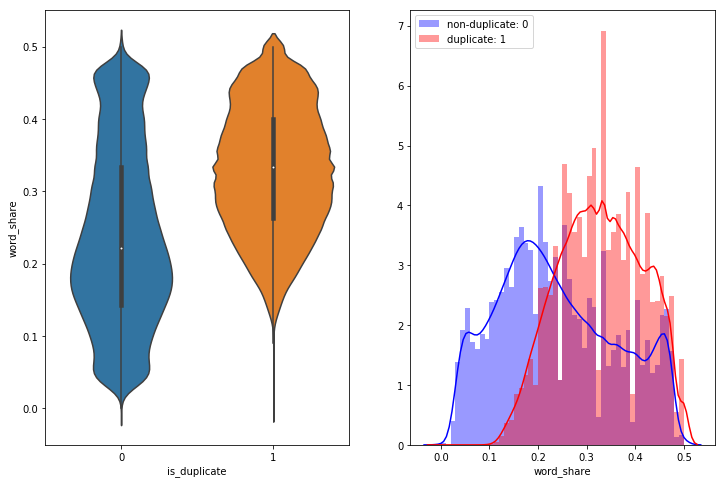

In [20]:
plt.figure(figsize=(12, 8))

plt.subplot(1, 2, 1);
sns.violinplot(x = 'is_duplicate', y = 'word_share', data=X_train);

plt.subplot(1, 2, 2);
sns.distplot(X_train[ X_train['is_duplicate'] == 0 ]['word_share'], label="non-duplicate: 0", color="blue");
sns.distplot(X_train[ X_train["is_duplicate"] == 1 ]['word_share'], label="duplicate: 1", color="red");

plt.legend();
plt.show()

<h2>Observations</h2>
<ul>
    <li>In violin plot as we can see that box-plot are overlapping but not completely, that means it is giving some differnce for duplicacy.</li>
    <li>In dist plot we can see that word share is more duplicates word and plot for both is also not overlapping completely, that means feature word_share is giving some information about duplicacy.</li>
</ul>

### Feature: word_Common

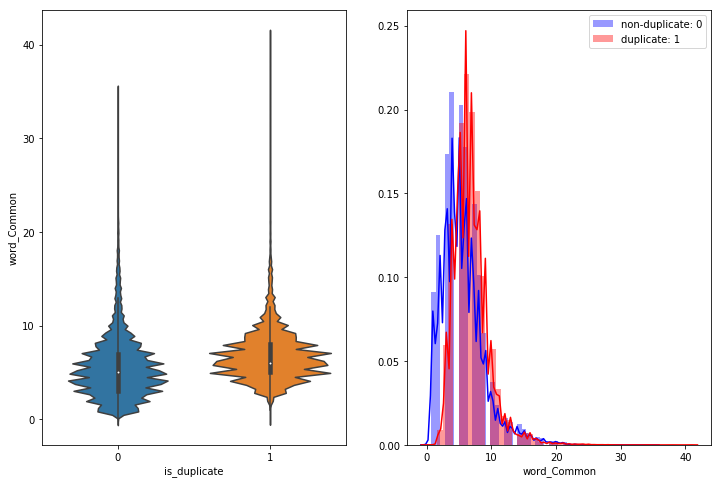

In [21]:
plt.figure(figsize=(12, 8));

plt.subplot(1, 2, 1);
sns.violinplot(x='is_duplicate', y='word_Common', data=X_train);

plt.subplot(1, 2, 2);
sns.distplot(X_train[ df['is_duplicate'] == 0 ]['word_Common'], label="non-duplicate: 0", color="blue");
sns.distplot(X_train[ df['is_duplicate'] == 1 ]['word_Common'], label="duplicate: 1", color="red");

plt.legend();
plt.show()

<h3>Observations</h3>
both the plots are too much overlapping we are hardly getting any difference using this feature

### Feature: freq_q1+freq_q2

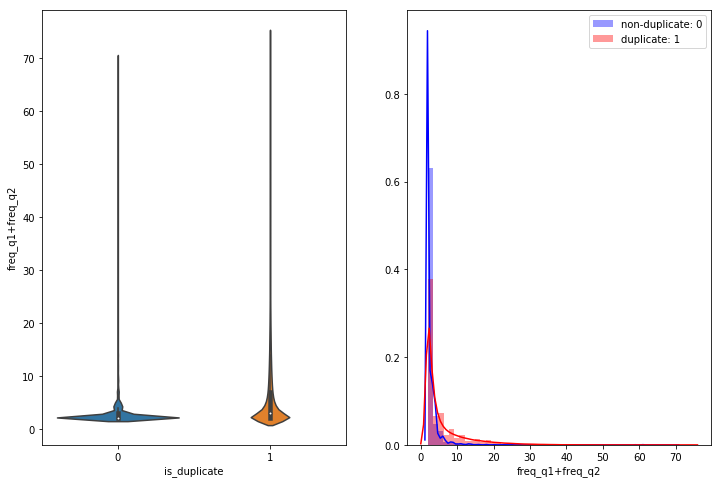

In [22]:
plt.figure(figsize=(12, 8));

plt.subplot(1, 2, 1);
sns.violinplot(x='is_duplicate', y='freq_q1+freq_q2', data=X_train);

plt.subplot(1, 2, 2);
sns.distplot(X_train[ df['is_duplicate'] == 0 ]['freq_q1+freq_q2'], label="non-duplicate: 0", color="blue");
sns.distplot(X_train[ df['is_duplicate'] == 1 ]['freq_q1+freq_q2'], label="duplicate: 1", color="red");

plt.legend();
plt.show()

<h3>Pair Plot of features: word_Common, word_Total, word_share, freq_q1+freq_q2, freq_q1-freq_q2</h3>

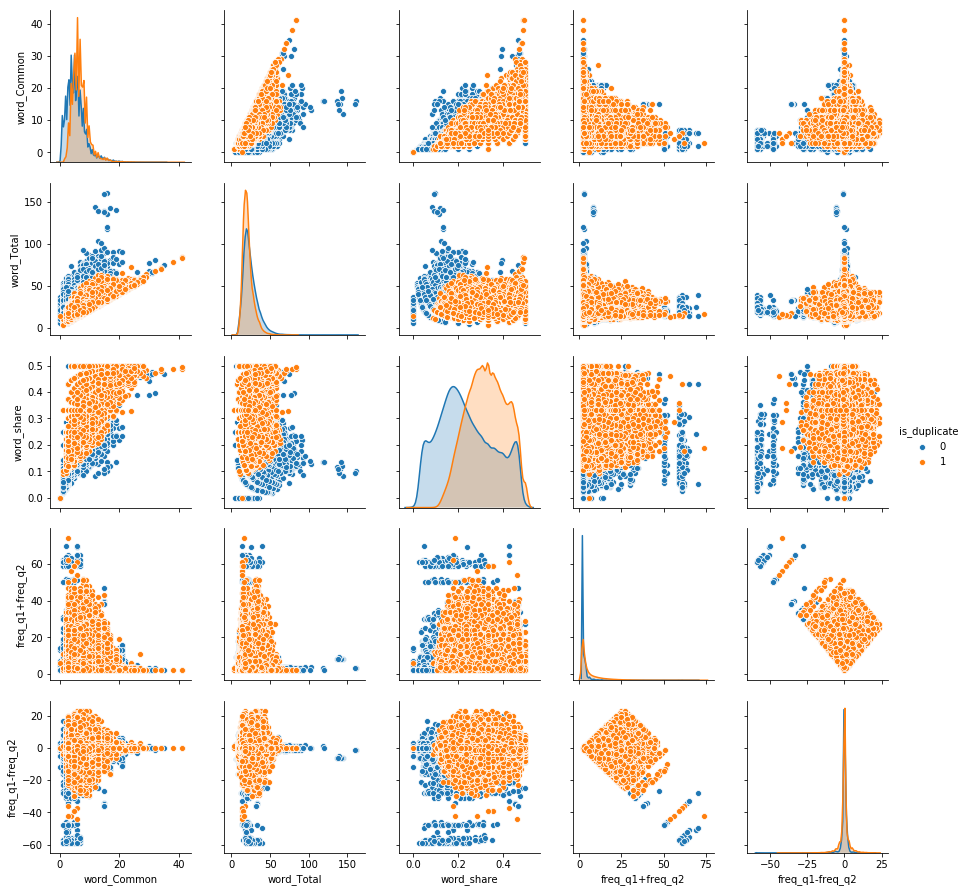

In [23]:
n = X_train.shape[0]
sns.pairplot(X_train[['word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2', 'freq_q1-freq_q2', 'is_duplicate']][0:n], hue='is_duplicate', vars=['word_Common', 'word_Total', 'word_share', 'freq_q1+freq_q2', 'freq_q1-freq_q2'])
plt.show()